# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

from time import localtime, strftime
import os, re, gc, joblib
import numpy as np
import numpy_groupies as npg
import pandas as pd

import anndata
import scanpy as sc
import sctk as sk

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import seaborn as sn
import plotnine as pln
from datetime import date

# YYYY-MM-DD
today = date.today()
today = today.strftime("%Y-%m-%d")

In [2]:
np.set_printoptions(linewidth=150)

rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42

sc.settings.verbosity = 0
expr_cmap = sk.expression_colormap()
sk.set_figsize((4, 4))

In [3]:
def timestamp(date_only=True):
    stamp_format = "%Y%m%d" if date_only else "%Y%m%d-%H%M"
    return strftime(stamp_format, localtime())

In [4]:
def get_reaction_consistencies(compass_reaction_penalties, min_range=1e-3):
    """
    Converts the raw penalties outputs of compass into scores per reactions where higher numbers indicate more activity
    """
    df = -np.log(compass_reaction_penalties + 1)
    df = df[df.max(axis=1) - df.min(axis=1) >= min_range]
    df = df - df.min().min()
    return df

# Load data

In [5]:
cell_md= pd.read_csv('/nfs/team205/heart/compass/fetal_allCM_random10/cell_metadata.csv', index_col = 0)
cell_md

/tmp/ipykernel_14811/4061232216.py:1: DtypeWarning: Columns (35,40) have mixed types. Specify dtype option on import or set low_memory=False.


latent_RT_efficiency  \
barcode                                                                    
BHF_F_Hea10402917_GATCGATAGACCCACC-1                            3.064704   
BHF_F_Hea10402917_CATCAAGCATGGGACA-1                            3.019039   
BHF_F_Hea10402917_CACCACTAGAGTGAGA-1                            2.600170   
BHF_F_Hea10402917_TCTTTCCTCTGGTGTA-1                            2.481375   
BHF_F_Hea10402917_AAATGCCGTCAACATC-1                            2.400682   
...                                                                  ...   
BHF_F_Hea11933675_BHF_F_Hea11596628_CCTGTTGGTTG...              0.977603   
BHF_F_Hea11933675_BHF_F_Hea11596628_GCGCTAGGTGT...              0.861791   
BHF_F_Hea11933675_BHF_F_Hea11596628_AGCTACGTCTT...              0.811526   
BHF_F_Hea11933675_BHF_F_Hea11596628_CTGCTATGTTT...              0.807019   
BHF_F_Hea11933675_BHF_F_Hea11596628_GGCCTTAAGGC...              0.769857   

                                                    latent_cell_probability  \
barcode                                                                       
BHF_F_Hea10402917_GATCGATAGACCCACC-1                               0.999994   
BHF_F_Hea10402917_CATCAAGCATGGGACA-1                               0.999993   
BHF_F_Hea10402917_CACCACTAGAGTGAGA-1                               0.999989   
BHF_F_Hea10402917_TCTTTCCTCTGGTGTA-1                               0.999992   
BHF_F_Hea10402917_AAATGCCGTCAACATC-1                               0.999959   
...                                                                     ...   
BHF_F_Hea11933675_BHF_F_Hea11596628_CCTGTTGGTTG...                 0.998388   
BHF_F_Hea11933675_BHF_F_Hea11596628_GCGCTAGGTGT...                 0.997482   
BHF_F_Hea11933675_BHF_F_Hea11596628_AGCTACGTCTT...                 0.990161   
BHF_F_Hea11933675_BHF_F_Hea11596628_CTGCTATGTTT...                 0.987438   
BHF_F_Hea11933675_BHF_F_Hea11596628_GGCCTTAAGGC...                 0.965501   

                                                    latent_scale  \
barcode                                                            
BHF_F_Hea10402917_GATCGATAGACCCACC-1                10902.040039   
BHF_F_Hea10402917_CATCAAGCATGGGACA-1                 9811.644531   
BHF_F_Hea10402917_CACCACTAGAGTGAGA-1                 8616.544922   
BHF_F_Hea10402917_TCTTTCCTCTGGTGTA-1                 8874.579102   
BHF_F_Hea10402917_AAATGCCGTCAACATC-1                 7570.651855   
...                                                          ...   
BHF_F_Hea11933675_BHF_F_Hea11596628_CCTGTTGGTTG...   2734.687744   
BHF_F_Hea11933675_BHF_F_Hea11596628_GCGCTAGGTGT...   4039.140381   
BHF_F_Hea11933675_BHF_F_Hea11596628_AGCTACGTCTT...   4187.259766   
BHF_F_Hea11933675_BHF_F_Hea11596628_CTGCTATGTTT...   3982.637451   
BHF_F_Hea11933675_BHF_F_Hea11596628_GGCCTTAAGGC...   3725.604004   

                                                             sangerID  \
barcode                                                                 
BHF_F_Hea10402917_GATCGATAGACCCACC-1                BHF_F_Hea10402917   
BHF_F_Hea10402917_CATCAAGCATGGGACA-1                BHF_F_Hea10402917   
BHF_F_Hea10402917_CACCACTAGAGTGAGA-1                BHF_F_Hea10402917   
BHF_F_Hea10402917_TCTTTCCTCTGGTGTA-1                BHF_F_Hea10402917   
BHF_F_Hea10402917_AAATGCCGTCAACATC-1                BHF_F_Hea10402917   
...                                                               ...   
BHF_F_Hea11933675_BHF_F_Hea11596628_CCTGTTGGTTG...  BHF_F_Hea11933675   
BHF_F_Hea11933675_BHF_F_Hea11596628_GCGCTAGGTGT...  BHF_F_Hea11933675   
BHF_F_Hea11933675_BHF_F_Hea11596628_AGCTACGTCTT...  BHF_F_Hea11933675   
BHF_F_Hea11933675_BHF_F_Hea11596628_CTGCTATGTTT...  BHF_F_Hea11933675   
BHF_F_Hea11933675_BHF_F_Hea11596628_GGCCTTAAGGC...  BHF_F_Hea11933675   

                                                                             combinedID  \
barcode                                                                                   
BHF_F_Hea10402917_

In [6]:
cluster_md=pd.read_csv(('/nfs/team205/heart/compass/fetal_allCM_random10/cluster_md.csv'))
cluster_md

label clus_cell_or_nuclei clus_age  \
0         VentricularCardiomyocytesPRRX1pos,965              Nuclei    15W1D   
1          VentricularCardiomyocytesCycling,900              Nuclei    15W1D   
2          VentricularCardiomyocytesCompact,955              Nuclei    15W1D   
3     VentricularCardiomyocytesTrabeculated,176              Nuclei    15W1D   
4                        Cardiofibromyocytes,18              Nuclei    15W1D   
...                                         ...                 ...      ...   
6471            SinoatrialNodeCardiomyocytes,74              Nuclei    15W1D   
6472       VentricularCardiomyocytesCompact,685              Nuclei    15W1D   
6473       VentricularCardiomyocytesCompact,978              Nuclei    15W1D   
6474      VentricularCardiomyocytesCompact,1210              Nuclei    15W1D   
6475              AtrialCardiomyocytesRight,489              Nuclei    15W1D   

     clus_kit_10x clus_facility  clus_n_genes  clus_n_counts  \
0     Multiome-v1        Sanger        2597.1         8730.2   
1     Multiome-v1        Sanger        2442.3         8131.9   
2     Multiome-v1        Sanger        2285.7         7799.9   
3     Multiome-v1        Sanger        2745.2         9356.4   
4     Multiome-v1        Sanger        2670.9         7234.1   
...           ...           ...           ...            ...   
6471  Multiome-v1        Sanger        2151.8         4906.6   
6472  Multiome-v1        Sanger        1563.7         3278.4   
6473  Multiome-v1        Sanger        2136.0         5108.6   
6474  Multiome-v1        Sanger        2034.6         5193.3   
6475  Multiome-v1        Sanger        2273.5         6583.0   

      clus_total_counts  clus_total_counts_mt  clus_total_counts_ribo  
0                8730.2                 322.1                   323.1  
1                8131.9                 402.4                   436.5  
2                7799.9                 253.5                   492.6  
3                9356.4                 601.3                   434.7  
4                7234.1                 128.4                   154.6  
...                 ...                   ...                     ...  
6471             4906.6                  35.3                    43.0  
6472             3278.4                  51.4                    33.2  
6473             5108.6                  71.2                    68.9  
6474             5193.3                  88.9                    56.4  
6475             6583.0                  88.3                    50.1  

[6476 rows x 10 columns]

In [7]:
# this is a reference file - not specific to each run of Compass
reaction_metadata = pd.read_csv("/home/jovyan/COMPASSResources/reaction_metadata.csv", index_col = 0)
reaction_metadata

reaction_name  \
reaction_no_direction                                               
10FTHF5GLUtl               5-glutamyl-10FTHF transport, lysosomal   
10FTHF5GLUtm           5-glutamyl-10FTHF transport, mitochondrial   
10FTHF6GLUtl               6-glutamyl-10FTHF transport, lysosomal   
10FTHF6GLUtm           6-glutamyl-10FTHF transport, mitochondrial   
10FTHF7GLUtl               7-glutamyl-10FTHF transport, lysosomal   
...                                                           ...   
MAL_Lte                                     Transport of L-malate   
OROTGLUt                                                 OROTGLUt   
PNTOte                              Transport of (R)-Pantothenate   
IDOURte                      L-iduronate transport, extracellular   
EX_idour(e)                               Exchange of L-iduronate   

                                                                 formula  \
reaction_no_direction                                                      
10FTHF5GLUtl           1.00 * 10-formyltetrahydrofolate-[Glu](5) [c] ...   
10FTHF5GLUtm           1.00 * 10-formyltetrahydrofolate-[Glu](5) [m] ...   
10FTHF6GLUtl           1.00 * 10-formyltetrahydrofolate-[Glu](6) [c] ...   
10FTHF6GLUtm           1.00 * 10-formyltetrahydrofolate-[Glu](6) [m] ...   
10FTHF7GLUtl           1.00 * 10-formyltetrahydrofolate-[Glu](7) [c] ...   
...                                                                  ...   
MAL_Lte                1.00 * (S)-malate(2-) [e] --> 1.00 * (S)-malat...   
OROTGLUt               1.00 * L-glutamate(1-) [c] + 1.00 * Orotate [e...   
PNTOte                 1.00 * (R)-Pantothenate [e] --> 1.00 * (R)-Pan...   
IDOURte                1.00 * L-iduronate [e] --> 1.00 * L-iduronate ...   
EX_idour(e)                       1.00 * L-iduronate [e] --> ϕ\nNo genes   

                      associated_genes                 subsystem EC_number  \
reaction_no_direction                                                        
10FTHF5GLUtl                       NaN      Transport, lysosomal       NaN   
10FTHF5GLUtm                       NaN  Transport, mitochondrial       NaN   
10FTHF6GLUtl                       NaN      Transport, lysosomal       NaN   
10FTHF6GLUtm                       NaN  Transport, mitochondrial       NaN   
10FTHF7GLUtl                       NaN      Transport, lysosomal       NaN   
...                                ...                       ...       ...   
MAL_Lte                            NaN  Transport, extracellular       NaN   
OROTGLUt                       SLC22A7  Transport, extracellular       NaN   
PNTOte                             NaN  Transport, extracellular       NaN   
IDOURte                            NaN  Transport, extracellular       NaN   
EX_idour(e)                        NaN  Exchange/demand reaction       NaN   

                       confidence  
reaction_no_direction              
10FTHF5GLUtl                  2.0  
10FTHF5GLUtm                  2.0  
10FTHF6GLUtl                  2.0  
10FTHF6GLUtm                  2.0  
10FTHF7GLUtl                  2.0  
...                           ...  
MAL_Lte                       NaN  
OROTGLUt                      NaN  
PNTOte                        NaN  
IDOURte                       NaN  
EX_idour(e)                   NaN  

[7440 rows x 6 columns]

In [8]:
#Inspect the reactions
rxns=get_reaction_consistencies(pd.read_csv("/nfs/team205/heart/compass/fetal_allCM_random10/out/reactions.tsv", sep="\t", index_col=0)).T
rxns.head(3)

10FTHF5GLUtl_pos  10FTHF5GLUtm_pos  \
AtrialCardiomyocytesCycling,0           3.583762          3.229782   
AtrialCardiomyocytesCycling,1           3.589048          3.227855   
AtrialCardiomyocytesCycling,10          3.570372          3.255463   

                                10FTHF6GLUtl_pos  10FTHF6GLUtm_pos  \
AtrialCardiomyocytesCycling,0           3.366421          3.155022   
AtrialCardiomyocytesCycling,1           3.373341          3.153456   
AtrialCardiomyocytesCycling,10          3.348559          3.187550   

                                10FTHF7GLUtl_pos  10FTHF7GLUtm_pos  \
AtrialCardiomyocytesCycling,0           3.245352          3.108076   
AtrialCardiomyocytesCycling,1           3.251893          3.106718   
AtrialCardiomyocytesCycling,10          3.247583          3.144681   

                                10FTHFtl_neg  10FTHFtm_neg  10FTHFtm_pos  \
AtrialCardiomyocytesCycling,0       3.583762      2.793539      1.835132   
AtrialCardiomyocytesCycling,1       3.589048      2.758867      1.798729   
AtrialCardiomyocytesCycling,10      3.570372      2.750323      1.818878   

                                11DOCRTSLtm_pos  ...  sink_5hpet(c)_pos  \
AtrialCardiomyocytesCycling,0          0.611826  ...           6.947103   
AtrialCardiomyocytesCycling,1          0.612801  ...           6.937098   
AtrialCardiomyocytesCycling,10         0.605847  ...           6.941168   

                                sink_c101coa(c)_neg  sink_c81coa(c)_neg  \
AtrialCardiomyocytesCycling,0              2.005844            2.005844   
AtrialCardiomyocytesCycling,1              1.984764            1.984764   
AtrialCardiomyocytesCycling,10             1.987284            1.987284   

                                sink_citr(c)_pos  sink_dd2coa(c)_neg  \
AtrialCardiomyocytesCycling,0           1.738828            2.005844   
AtrialCardiomyocytesCycling,1           1.713967            1.984764   
AtrialCardiomyocytesCycling,10          1.758712            1.987284   

                                sink_decdicoa(c)_neg  sink_octdececoa(c)_neg  \
AtrialCardiomyocytesCycling,0               2.005844                1.656541   
AtrialCardiomyocytesCycling,1               1.984764                1.624637   
AtrialCardiomyocytesCycling,10              1.987284                1.649227   

                                sink_pre_prot(r)_neg  sink_tetdec2coa(c)_neg  \
AtrialCardiomyocytesCycling,0               7.479271                2.005844   
AtrialCardiomyocytesCycling,1               7.480046                1.984764   
AtrialCardiomyocytesCycling,10              7.482232                1.987284   

                                sink_tetdece1coa(c)_neg  
AtrialCardiomyocytesCycling,0                  2.005844  
AtrialCardiomyocytesCycling,1                  1.984764  
AtrialCardiomyocytesCycling,10                 1.987284  

[3 rows x 6508 columns]

In [9]:
means=rxns.mean()
stds=rxns.std()

<AxesSubplot:>

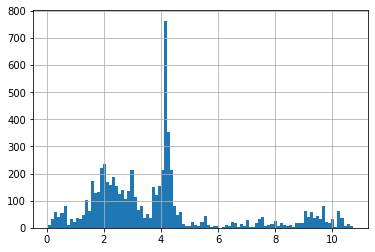

In [10]:
means.hist(bins=100)

<AxesSubplot:>

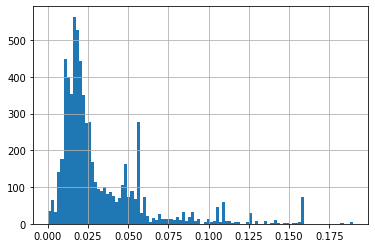

In [11]:
stds.hist(bins=100)

There is very little variability in reactions across cell states

In [12]:
# read in reaction penalties, convert to consistencies, and transpose for scanpy
pooled_ad = anndata.AnnData(rxns)

/tmp/ipykernel_14811/3267771824.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [13]:
# add the cell state label to .obs
pooled_ad.obs['compass_sample_id']=pooled_ad.obs.index
pooled_ad.obs[['fine_grain','cluster']]=pooled_ad.obs['compass_sample_id'].str.split(',', expand=True)

In [14]:
# Add the metadata
cluster_md=cluster_md.set_index('label')
pooled_ad.obs=pooled_ad.obs.merge(cluster_md,left_index=True,right_index=True)

In [15]:
#add in a mid-grain annotation

old_to_new = {
    'AtrialCardiomyocytesCycling':'Atrial_cycling',
    'AtrialCardiomyocytesLeft':'Atrial_CM',
    'AtrialCardiomyocytesRight':'Atrial_CM',
    'AtrioventricularNodeCardiomyocytes':'CCS',
    'Cardiofibromyocytes':'Cardiofibromyocytes',
    'VentricularCardiomyocytesCycling':'Ventricular_cycling',
    'VentricularCardiomyocytesPRRX1pos':'Ventricular_CM',
    'VentricularCardiomyocytesTrabeculated':'Ventricular_CM',
    'VentricularCardiomyocytesCompact':'Ventricular_CM',
    'VentricularConductionSystemDistal':'CCS',
    'VentricularConductionSystemProximal':'CCS',
    'SinoatrialNodeCardiomyocytes':'CCS',
}
pooled_ad.obs['mid_grain'] = (
    pooled_ad.obs['fine_grain']
    .map(old_to_new)
    .astype('category')
)

In [16]:
# get reaction ID column
pooled_ad.var['metadata_r_id'] = ""
for r in pooled_ad.var.index:
    if r in reaction_metadata.index:
        pooled_ad.var.loc[r, 'metadata_r_id'] = r
    elif r[:-4] in reaction_metadata.index:
        pooled_ad.var.loc[r, 'metadata_r_id'] = r[:-4]
    else:
        print("Should not occur")

In [17]:
pooled_ad.var=pooled_ad.var.merge(reaction_metadata, how='left',
                         left_on='metadata_r_id', right_index=True, validate='m:1')

<AxesSubplot:>

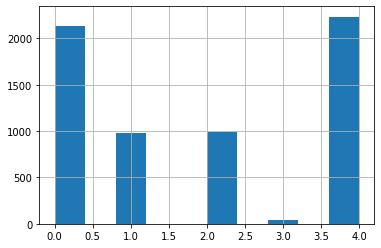

In [18]:
pooled_ad.var['confidence'].hist()

In [19]:
# remove reactions with confidences that are not 0 or 4
print(pooled_ad.shape)
pooled_ad=pooled_ad[:,pooled_ad.var['confidence'].isin([4])]
print(pooled_ad.shape)

(6476, 6508)
(6476, 2235)


In [20]:
pooled_ad.write(f"/nfs/team205/heart/compass/fetal_allCM_random10/compass.anndata_converted.{today}.h5ad")

/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
/home/jovyan/my-conda-envs/sca

# Subset to just trabeculated and compact

In [21]:
print(pooled_ad.shape)
pooled_ad=pooled_ad[pooled_ad.obs['fine_grain'].isin(['VentricularCardiomyocytesTrabeculated','VentricularCardiomyocytesCompact'])]
print(pooled_ad.shape)

(6476, 2235)
(2068, 2235)


# Process

In [22]:
pooled_ad0 = pooled_ad.copy()

## QC

Distribution seems very different from nUMI

Let's take a closer look

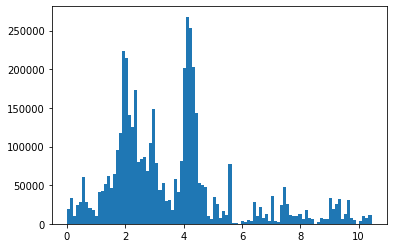

In [23]:
plt.hist(pooled_ad0.X.flatten(), 100);

Distribution very multi-modal

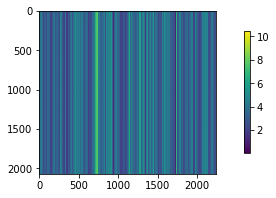

In [24]:
sk.set_figsize((10, 3))
plt.imshow(pooled_ad0.X)
plt.colorbar(shrink=0.75);

## Clustering by metabolic state: all clusters

In [25]:
adata = pooled_ad0.copy()

In [26]:
print(pooled_ad0.X.mean())
print(pooled_ad0.X.std())

3.5985098
2.1082776


In [27]:
#log normalising
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [28]:
print(adata.X.mean())
print(adata.X.std())

1.5897808
0.47859952


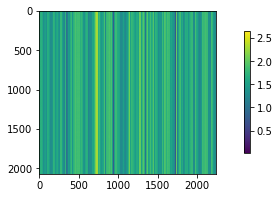

In [29]:
sk.set_figsize((10, 3))
plt.imshow(adata.X)
plt.colorbar(shrink=0.75);

In [30]:
adata.raw.X.sum(axis=1).min(), adata.raw.X.sum(axis=1).max()

(3545.7983, 3559.983)

### highly variable features only

In [31]:
sc.pp.highly_variable_genes(adata)

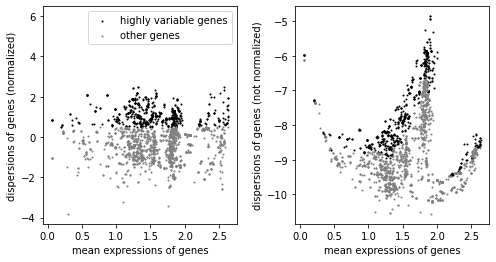

In [32]:
sk.set_figsize((4, 4))
sc.pl.highly_variable_genes(adata)

In [33]:
print(adata.shape)
adata = adata[:, adata.var.highly_variable]
print(adata.shape)

(2068, 2235)
(2068, 703)


In [34]:
sc.pp.scale(adata, zero_center=True, max_value=10)

/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.


In [35]:
sc.pp.pca(adata, use_highly_variable=True)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=14)
sc.tl.umap(adata,min_dist=0.1)

/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


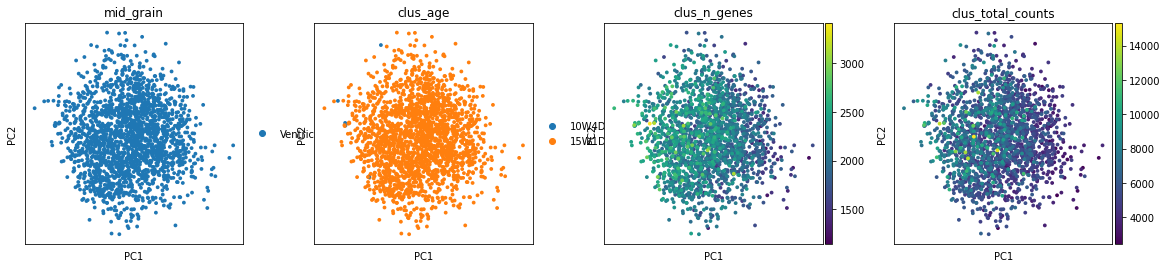

In [36]:
sc.pl.pca(adata,color=['fine_grain','clus_age','clus_n_genes','clus_total_counts'])

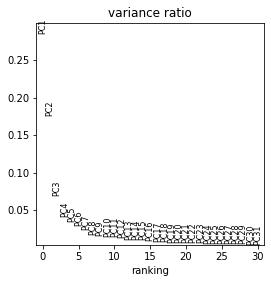

In [37]:
sc.pl.pca_variance_ratio(adata)

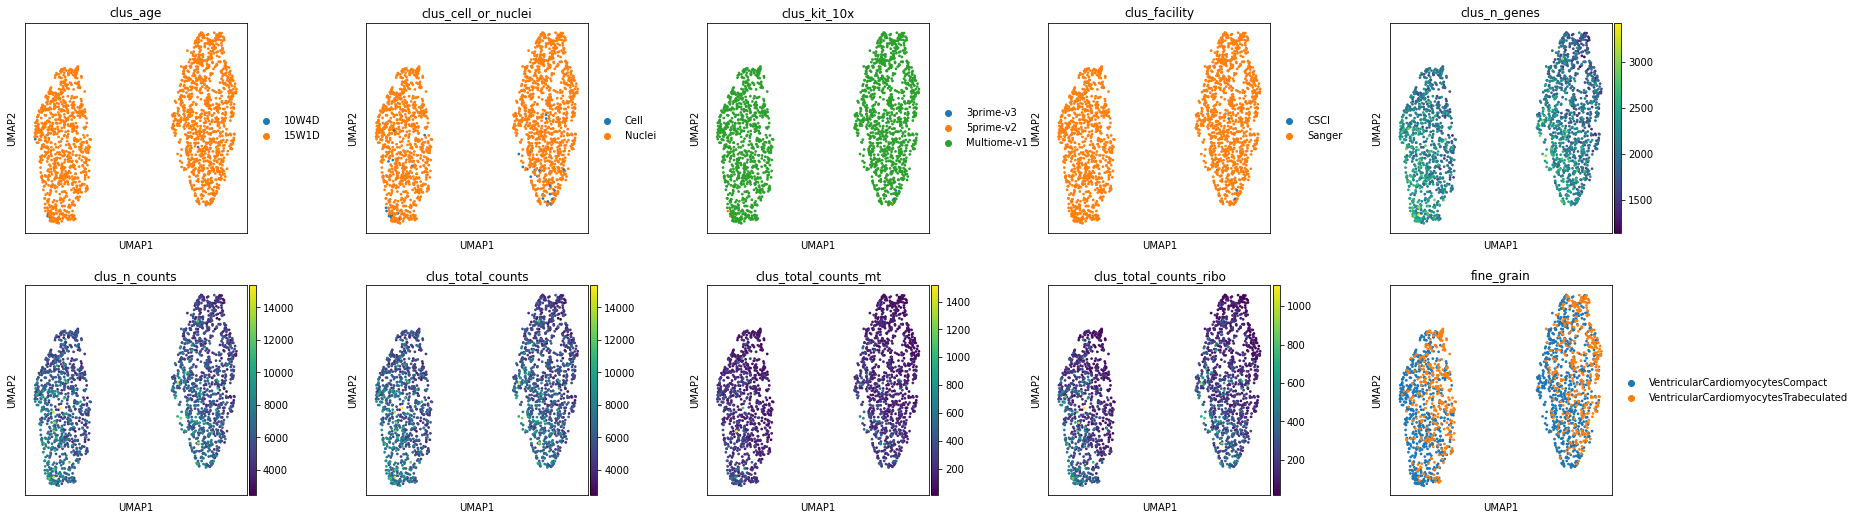

In [38]:
sc.pl.umap(adata, color=["clus_age","clus_cell_or_nuclei","clus_kit_10x","clus_facility","clus_n_genes","clus_n_counts","clus_total_counts","clus_total_counts_mt","clus_total_counts_ribo","fine_grain"], wspace=0.4, size=30,ncols=5)

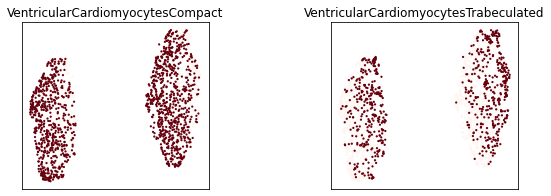

In [40]:
sk.highlight(
    adata, basis="umap", groupby="fine_grain", wspace=0.5, figsize=(3, 3), size=20, ncols=3
)

In [41]:
sc.tl.leiden(adata, resolution=0.2, key_added="leiden")

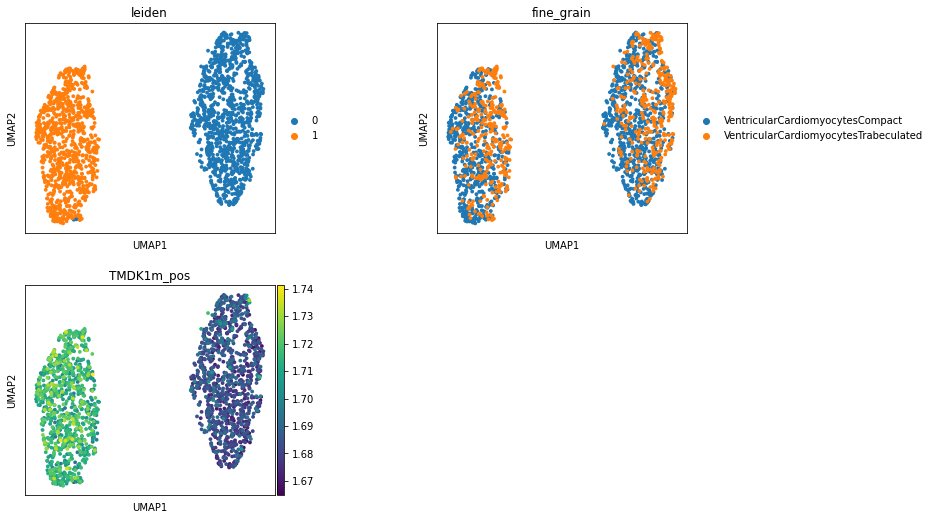

In [42]:
sk.set_figsize((4, 4))
sc.pl.umap(adata,color=["leiden",'fine_grain','TMDK1m_pos'],ncols=2,wspace=0.5)

In [43]:
sc.tl.rank_genes_groups(adata,
                       groupby='leiden')

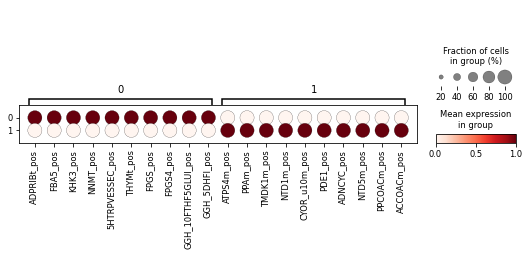

In [44]:
sc.pl.rank_genes_groups_dotplot(adata,
                               n_genes=10,
                               standard_scale='var')

In [45]:
subsystem_list=[]
for subsystem in adata.var['subsystem'].unique().tolist():
    sc.tl.score_genes(
        adata,
        adata.var.index[adata.var['subsystem']==subsystem].tolist(),
        score_name=subsystem
                 )
    subsystem_list.append(subsystem)

/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will ra

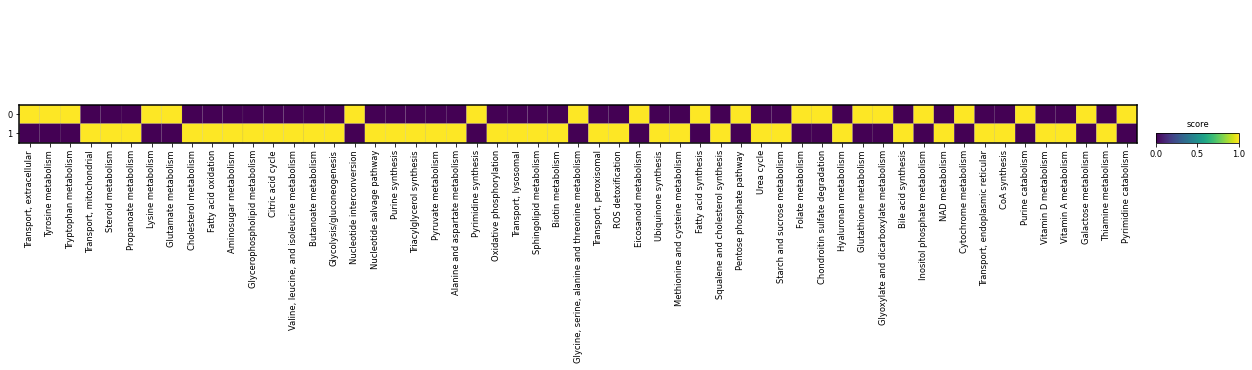

In [46]:
sc.pl.matrixplot(adata,
              var_names=subsystem_list,
              groupby='leiden',
             dendrogram=True,
                colorbar_title='score',
                standard_scale='var')

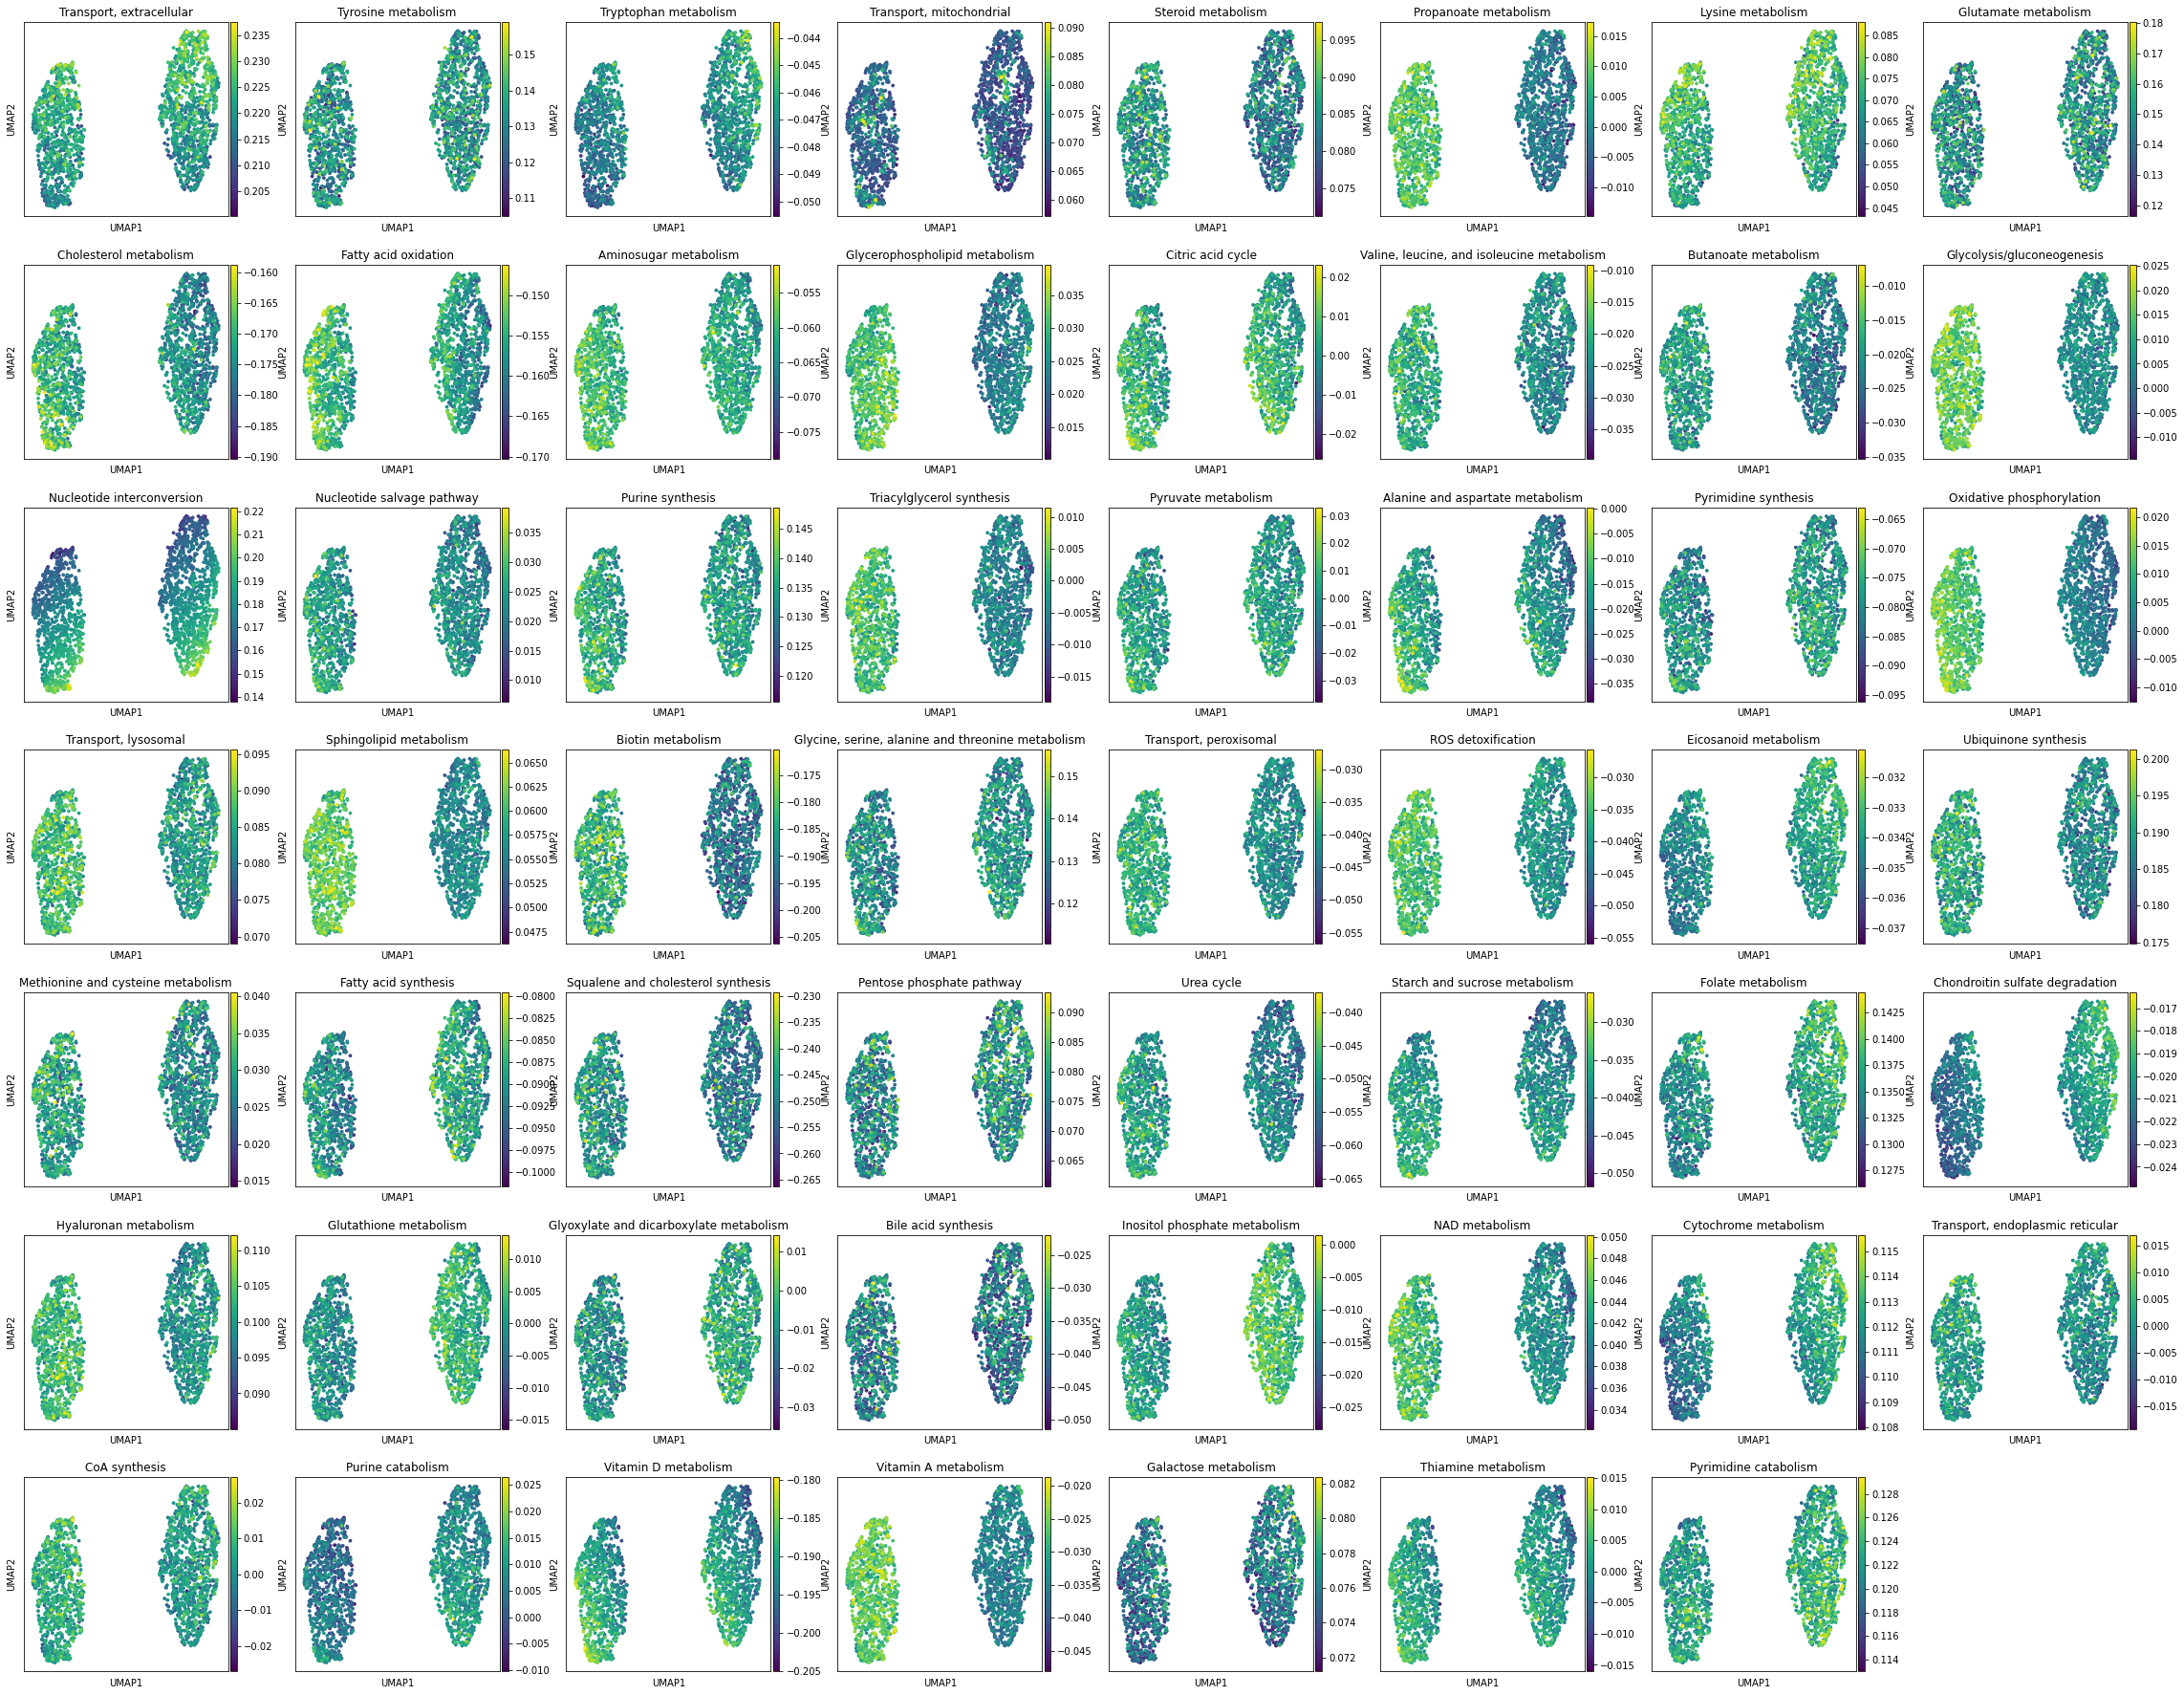

In [47]:
sk.set_figsize((4, 4))
sc.pl.umap(adata, color=subsystem_list,ncols=8)

# Subset just one of the halves

In [48]:
print(adata.shape)
adata=adata[adata.obs['leiden']=='1']
print(adata.shape)

(2068, 703)
(950, 703)


In [49]:
sc.pp.pca(adata, use_highly_variable=True)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=14)
sc.tl.umap(adata, min_dist=0.1)

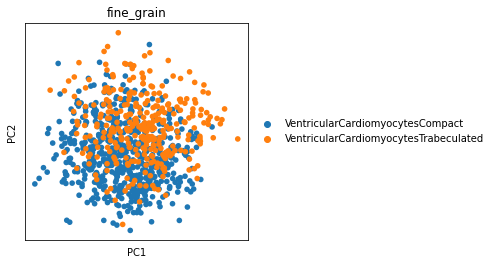

In [50]:
sc.pl.pca(adata,color='fine_grain')

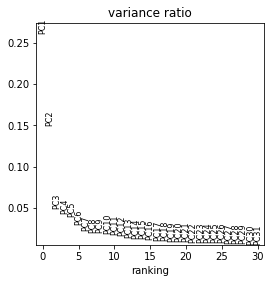

In [51]:
sc.pl.pca_variance_ratio(adata)

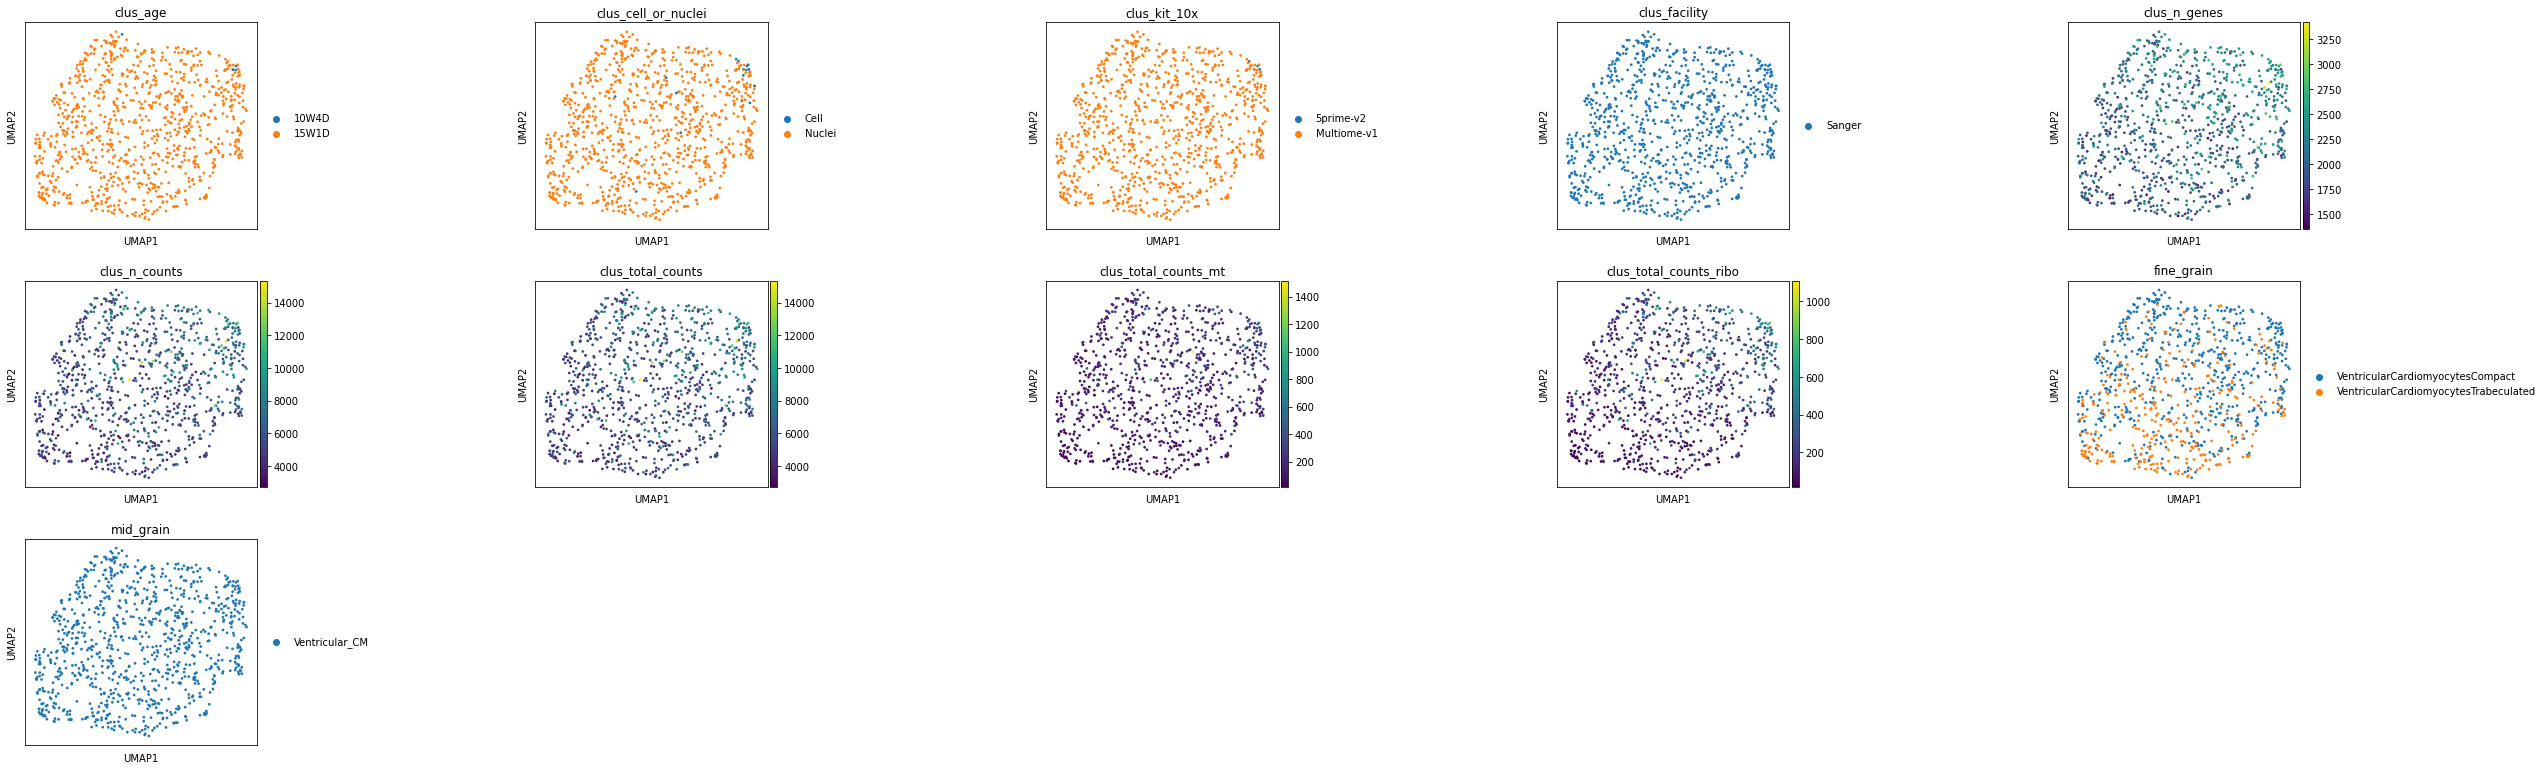

In [52]:
sc.pl.umap(adata, color=["clus_age","clus_cell_or_nuclei","clus_kit_10x","clus_facility","clus_n_genes","clus_n_counts","clus_total_counts","clus_total_counts_mt","clus_total_counts_ribo","fine_grain",'mid_grain'], wspace=1, size=30,ncols=5)

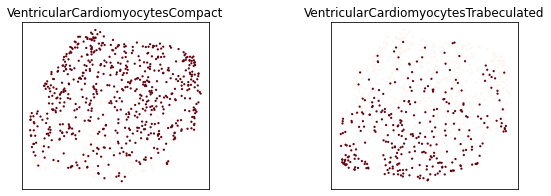

In [53]:
sk.highlight(
    adata, basis="umap", groupby="fine_grain", wspace=0.5, figsize=(3, 3), size=20, ncols=3
)

In [54]:
sc.tl.leiden(adata, resolution=0.2, key_added="leiden")

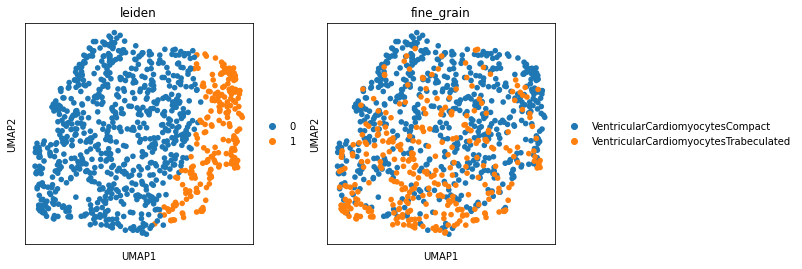

In [55]:
sk.set_figsize((4, 4))
sc.pl.umap(adata, color=["leiden",'fine_grain'])

In [56]:
sc.tl.rank_genes_groups(adata,
                       groupby='fine_grain')

In [57]:
sc.tl.dendrogram(adata,
                       groupby='fine_grain')

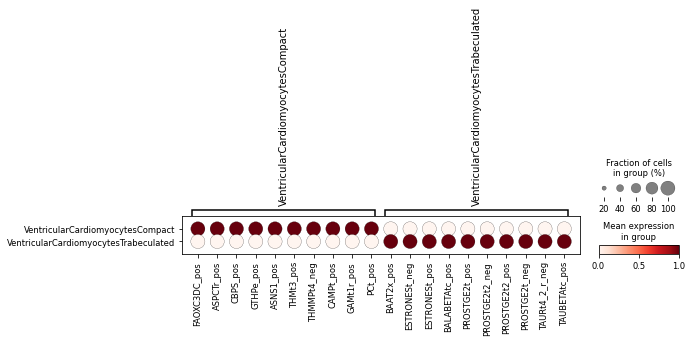

In [58]:
sc.pl.rank_genes_groups_dotplot(adata,
                               n_genes=10,
                               standard_scale='var')

In [59]:
subsystem_list=[]
for subsystem in adata.var['subsystem'].unique().tolist():
    sc.tl.score_genes(
        adata,
        adata.var.index[adata.var['subsystem']==subsystem].tolist(),
        score_name=subsystem
                 )
    subsystem_list.append(subsystem)

/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will ra

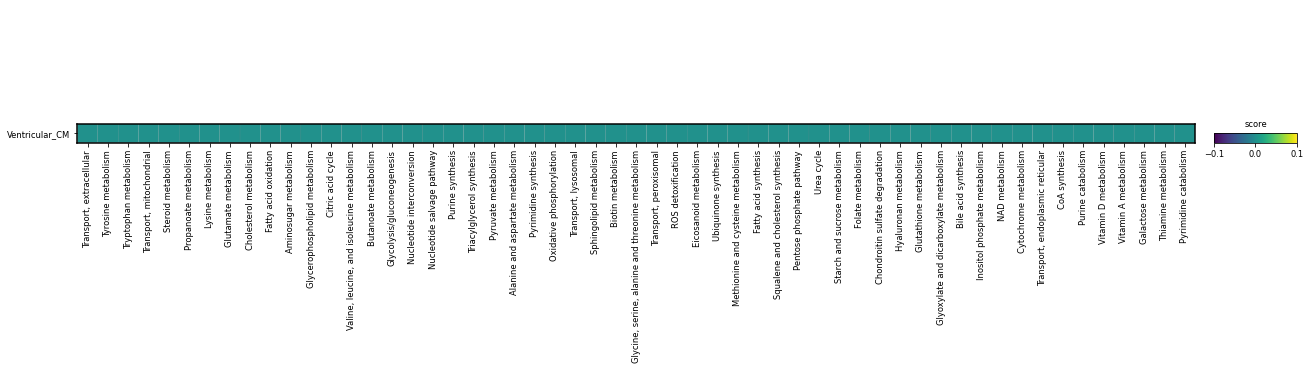

In [60]:
sc.pl.matrixplot(adata,
              var_names=subsystem_list,
              groupby='mid_grain',
             dendrogram=True,
                colorbar_title='score',
                standard_scale='var')

In [ ]:
tmp = pd.crosstab(adata.obs['leiden'],adata.obs['fine_grain'], normalize='index')
# tmp.plot.bar().legend(loc=1)
ax = tmp.plot.bar(stacked=True)
ax.grid(False)
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

In [ ]:
sk.set_figsize((4, 4))
sc.pl.umap(adata, color=subsystem_list,ncols=8)